In [1]:
# pip install matplotlib

In [2]:
# pip install rasterio

In [3]:
# pip install -U scikit-learn scipy

In [5]:
import numpy as np

In [34]:
from glob import glob

In [6]:
import matplotlib.pyplot as plt

In [7]:
import torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# Setup directory paths to train and test images
# train_dir = 'data/train/'
# val_dir = 'data/val'

In [11]:
NUM_WORKERS = os.cpu_count()

In [13]:
NUM_WORKERS

16

Experiment 1

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self,img_size,patch_size,in_chans=5,embed_dim=768):
        super().__init__()
        self.img_size=img_size
        self.patch_size=patch_size
        self.n_patches=(img_size//patch_size)**2
        self.in_chans=in_chans
        self.embed_dim=embed_dim
        
        self.proj = nn.Conv2d(
                    in_chans,
                    embed_dim,
                    kernel_size=patch_size,
                    stride=patch_size,
        )
    
    def forward(self,x):
        x = self.proj(
            x
        ) #(n_samples,embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2) #(n_samples,embd_dim, n_patches)
        x = x.transpose(1,2) #(n_samples,n_patches,embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self,dim,n_heads=12,qkv_bias=True,attn_p=0.,proj_p=0.):
        super().__init__()
        self.n_heads=n_heads
        self.dim = dim
        self.head_dim = dim//n_heads
        self.scale=self.head_dim ** -0.5
        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self,x):     
        n_samples,n_tokens,dim=x.shape
        
        
        if dim !=self.dim:
            raise ValueError
        
        qkv=self.qkv(x) #(n_samples,n_pacthes+1,3*dim)
        qkv=qkv.reshape(
        n_samples,n_tokens,3,self.n_heads,self.head_dim
        ) #n_samples,n_patches+1,3,n_heads, head_dim
        qkv=qkv.permute(
        2,0,3,1,4
        ) #(3,n_samples,n_heads,n_patches+1,head_dim)
        q,k,v = qkv[0],qkv[1],qkv[2]
        k_t = k.transpose(-2,-1) #(n_samples,n_heads,head_dim,n_patches+1) +1 corresponds to class token and it may not be necessary
        dp = (q @ k_t) *self.scale #(n_samples,n_heads,n_patches+1,n_patches+1) @ is shorthand for torch.matmul
        attn = dp.softmax(dim=-1) #(n_samples,n_heads,n_patches+1,n_patches+1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v #(n_samples,n_heads,n_patches+1,head_dim)
        weighted_avg = weighted_avg.transpose(1,2) #(n_samples,n_patches+1,n_heads,head_dim)
        weighted_avg = weighted_avg.flatten(2) #(n_samples,n_patches+1,dim)
        x = self.proj(weighted_avg) #(n_samples,n_patches+1,dim)
        x = self.proj_drop(x) #(n_samples,n_patches+1,dim)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1= nn.Linear(in_features,hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features,out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self,x):
        x = self.fc(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.act(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.drop(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.fc2(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.drop(x) #(n_samples,n_pacthes+1,hidden_features)
        return x

import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)  # eps = 1e-6 to match the pre-trained model
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=attn_p, bias=qkv_bias)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_features),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden_features, dim),
            nn.Dropout(p),
        )

    def forward(self, x):
        # Apply the attention mechanism
        x_norm1 = self.norm1(x).transpose(0, 1)  # Transpose for MultiheadAttention: (batch_size, seq_len, embed_dim) -> (seq_len, batch_size, embed_dim)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + attn_output.transpose(0, 1)  # Transpose back

        # Apply the MLP
        x = x + self.mlp(self.norm2(x))
        
        return x

class VisionTransformer(nn.Module):
    
    def __init__(
                self,
                img_size=384,
                patch_size=16,
                in_chans=3,
                n_classes=2,  # number of segmentation classes
                embed_dim=768,
                depth=12,
                n_heads=12,
                mlp_ratio=4.,
                qkv_bias=True,
                p=0.,
                attn_p=0,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
                        img_size = img_size,
                        patch_size= patch_size,
                        in_chans=in_chans,
                        embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                dim = embed_dim,
                n_heads = n_heads,
                mlp_ratio = mlp_ratio,
                qkv_bias = qkv_bias,
                p=p,
                attn_p = attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)
        
    def forward(self,x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        
        cls_token = self.cls_token.expand(
        n_samples,-1,-1
        ) #(n_samples,1,embed_dim)
        x = torch.cat((cls_token,x),dim=1) #(n_samples, 1+n_patches, embed_dim)
        x = x + self.pos_embed #(n_samples,1+n_patches,embed_dim)
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        
        cls_token_final = x[:,0] #just the cls token 
        x = self.head(cls_token_final)
        
        return x   

import numpy as np
import timm
import torch
# from custom import VisionTransformer

#helpers
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
def assert_tensors_equal(t1, t2, rtol=1e-3, atol=1e-6):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()
    np.testing.assert_allclose(a1, a2, rtol=rtol, atol=atol)

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name,pretrained = True)
model_official.eval()
print(type(model_official))

custom_config = {
    "img_size":384,
    "in_chans":3,
    "patch_size":16,
    "embed_dim":768,
    "depth":12,
    "n_heads":12,
    "qkv_bias":True,
    "mlp_ratio":4,
}

model_custom = VisionTransformer(**custom_config)
model_custom.eval()

for (n_o,p_o), (n_c,p_c) in zip(
        model_official.named_parameters(),model_custom.named_parameters()
):
    assert p_o.numel() == p_c.numel()
    print(f"{n_o} | {n_c}")
    p_c.data[:] = p_o.data
    assert_tensors_equal(p_c.data, p_o.data)
    
inp = torch.rand(1,3,384,384)
res_c = model_custom(inp)
res_o = model_official(inp)

#Asserts
assert get_n_params(model_custom) == get_n_params(model_official)
assert_tensors_equal(res_c,res_o)

#save custom model
# torch.save(model_custom,"model.pth")

# Code Starts HERE

In [185]:
class PatchEmbed(nn.Module):
    """""Split Images into patches and then embed them".
    Parameters
    _____
    img_size : int
    Size of the image (square)
    
    patch_size : int
    Size of the image(square)
    
    in_channels : int
    Number of input channels
    
    embed_dim : int
    THe embedding dimension
    
    Attributes
    ____________
    n_patches : int
    Number of patches inside of our image.
    
    proj: nn.Conv2d
    Convolutional layer that does both splitting into patches and their embedding.
    """
    def __init__(self,img_size,patch_size,in_chans=5,embed_dim=768):
        super().__init__()
        self.img_size=img_size
        self.patch_size=patch_size
        self.n_patches=(img_size//patch_size)**2
        self.in_chans=in_chans
        self.embed_dim=embed_dim
        
        self.proj = nn.Conv2d(
                    in_chans,
                    embed_dim,
                    kernel_size=patch_size,
                    stride=patch_size,
        )
    
    def forward(self,x):
        """"
        Run forward pass.
        
        Parameters
        __________
        x : torch.Tensor
        Shape '(n_samples, in_chans, img_size, img_size)'.
        
        Returns
        ________
        torch.Tensor
        Shape '(n_samples,n_patches,embed_dim)'.
        """
        x = self.proj(
            x
        ) #(n_samples,embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2) #(n_samples,embd_dim, n_patches)
        x = x.transpose(1,2) #(n_samples,n_patches,embed_dim)
        return x
    

In [186]:
class Attention(nn.Module):
    """"Attention Mechanism.
    
    Parameters
    __________
    dim: int
    The input and out dimension of per token features.
    
    n_heads : int
    Number of attention heads
    
    qkv_bias: bool
    If true then we include bias to the query, key value projections
    #qkv: A linear layer that projects the input into 
    query (Q), key (K), and value (V) matrices.
    
    attn_p: float
    Dropout prbability applied to query,key and value tensors.
    
    proj_p: float
    Droput probability applied to output tensor.
    
    
    Attributes
    _______________
    scale: float
    Normalizing constant for dot product
    
    qkv: nn.Linear
    Linear projection for query, key, value
    
    proj: nn.Linear
    Linear mapping that takes in concatenated output of all attention heads 
    and maps it into new space.
    
    attn_drop, proj_drop : nn.Dropout
    Dropout layers applied to the attention weights and final output, respectively.
    
    #attn_p: Dropout probability applied to the attention weights.
    #proj_p: Dropout probability applied to the final output of the attention mechanism.
    """
    
    def __init__(self,dim,n_heads=12,qkv_bias=True,attn_p=0.,proj_p=0.):
        super().__init__()
        self.n_heads=n_heads
        self.dim = dim
        self.head_dim = dim//n_heads
        self.scale=self.head_dim ** -0.5
        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self,x):
        """"Run Forward Pass.
        
        Parameters
        __________
        x: toch.Tensor
        Shape '(n_samples,n_patches+1,dim)'.
        
        Returns
        ______
        torch.Tensor
        Shape '(n_samples, n_patches+1,dim)'.
        """
        
        n_samples,n_tokens,dim=x.shape
        
        
        if dim !=self.dim:
            raise ValueError
        
        qkv=self.qkv(x) #(n_samples,n_pacthes+1,3*dim)
        qkv=qkv.reshape(
        n_samples,n_tokens,3,self.n_heads,self.head_dim
        ) #n_samples,n_patches+1,3,n_heads, head_dim
        qkv=qkv.permute(
        2,0,3,1,4
        ) #(3,n_samples,n_heads,n_patches+1,head_dim)
        q,k,v = qkv[0],qkv[1],qkv[2]
        k_t = k.transpose(-2,-1) #(n_samples,n_heads,head_dim,n_patches+1) +1 corresponds to class token and it may not be necessary
        dp = (q @ k_t) *self.scale #(n_samples,n_heads,n_patches+1,n_patches+1) @ is shorthand for torch.matmul
        attn = dp.softmax(dim=-1) #(n_samples,n_heads,n_patches+1,n_patches+1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v #(n_samples,n_heads,n_patches+1,head_dim)
        weighted_avg = weighted_avg.transpose(1,2) #(n_samples,n_patches+1,n_heads,head_dim)
        weighted_avg = weighted_avg.flatten(2) #(n_samples,n_patches+1,dim)
        x = self.proj(weighted_avg) #(n_samples,n_patches+1,dim)
        x = self.proj_drop(x) #(n_samples,n_patches+1,dim)
        return x
    


### Breaking it down line by line

### Understanding patch_embed

In [14]:
img_size=4
patch_size=2
n_patches=(img_size//patch_size)**2
in_chans=1
embed_dim=3
proj = nn.Conv2d(in_chans,embed_dim,kernel_size=patch_size,stride=patch_size)

In [15]:
proj

Conv2d(1, 3, kernel_size=(2, 2), stride=(2, 2))

In [16]:
x = torch.tensor([[[[1,2,3,4],
                   [5,6,7,8],
                   [9,10,11,12],
                   [13,14,15,16]]]],dtype=torch.float32)

In [17]:
x.shape

torch.Size([1, 1, 4, 4])

In [18]:
x

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [19]:
x = proj(x) #(n_samples,embed_dim, n_patches**0.5, n_patches**0.5)

In [20]:
x

tensor([[[[ 1.1235,  2.1950],
          [ 5.4097,  6.4813]],

         [[-1.6002, -2.1717],
          [-3.8861, -4.4576]],

         [[-1.3923, -2.5714],
          [-6.1089, -7.2880]]]], grad_fn=<ConvolutionBackward0>)

In [21]:
x.shape

torch.Size([1, 3, 2, 2])

In [22]:
x = x.flatten(2) #(n_samples,embd_dim, n_patches)

In [23]:
x.shape

torch.Size([1, 3, 4])

In [24]:
x

tensor([[[ 1.1235,  2.1950,  5.4097,  6.4813],
         [-1.6002, -2.1717, -3.8861, -4.4576],
         [-1.3923, -2.5714, -6.1089, -7.2880]]],
       grad_fn=<ReshapeAliasBackward0>)

In [25]:
x = x.transpose(1,2) #(n_samples,n_patches,embed_dim)

In [26]:
x

tensor([[[ 1.1235, -1.6002, -1.3923],
         [ 2.1950, -2.1717, -2.5714],
         [ 5.4097, -3.8861, -6.1089],
         [ 6.4813, -4.4576, -7.2880]]], grad_fn=<TransposeBackward0>)

In [27]:
n_samples,n_tokens,dim=x.shape

In [28]:
n_samples #batches??

1

In [29]:
n_tokens #patches

4

In [30]:
dim

3

### Dropout

In [31]:
p=0.5

In [32]:
module=torch.nn.Dropout(p)

In [33]:
module

Dropout(p=0.5, inplace=False)

In [34]:
module.training

True

In [35]:
inp=torch.ones(3,5)

In [36]:
inp

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [37]:
module(inp)

tensor([[0., 0., 0., 0., 2.],
        [0., 2., 0., 2., 2.],
        [0., 2., 2., 0., 2.]])

to compensate removal remaining multiplied with 
1/(1-p). Which in our case is 2

In [38]:
module.eval()

Dropout(p=0.5, inplace=False)

In [39]:
module.training

False

In [40]:
module(inp)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

### Understanding Q,K,V with heads = 1

In [41]:
# Attention(nn.Module):
n_heads=1
qkv_bias=True
attn_p=0.
proj_p=0.
dim = 3 #similar to number of patch
head_dim = dim//n_heads
scale=head_dim ** -0.5

In [42]:
head_dim

3

In [43]:
scale

0.5773502691896257

In [44]:
qkv=nn.Linear(dim,dim*3,bias=qkv_bias)

In [45]:
qkv

Linear(in_features=3, out_features=9, bias=True)

In [46]:
qkv.out_features

9

In [47]:
qkv.bias

Parameter containing:
tensor([ 0.0669, -0.0229,  0.4167,  0.3513, -0.5510, -0.2517,  0.4258, -0.2627,
        -0.0460], requires_grad=True)

In [48]:
x

tensor([[[ 1.1235, -1.6002, -1.3923],
         [ 2.1950, -2.1717, -2.5714],
         [ 5.4097, -3.8861, -6.1089],
         [ 6.4813, -4.4576, -7.2880]]], grad_fn=<TransposeBackward0>)

In [49]:
attn_drop = nn.Dropout(attn_p)
proj = nn.Linear(dim,dim)
proj_drop = nn.Dropout(proj_p)

In [50]:
attn_drop

Dropout(p=0.0, inplace=False)

In [51]:
proj

Linear(in_features=3, out_features=3, bias=True)

In [52]:
proj_drop

Dropout(p=0.0, inplace=False)

In [53]:
n_samples,n_tokens,dim=x.shape

In [54]:
if dim !=dim:
    raise ValueError

In [55]:
qkv=qkv(x)

In [56]:
qkv

tensor([[[-0.0422, -0.9465, -0.6428, -1.0833,  0.6609, -1.8605, -0.7159,
          -1.2452, -0.3997],
         [ 0.0841, -1.5066, -1.2345, -2.0475,  1.2670, -2.8278, -1.4745,
          -2.1862, -0.3301],
         [ 0.4630, -3.1870, -3.0097, -4.9402,  3.0855, -5.7297, -3.7503,
          -5.0091, -0.1213],
         [ 0.5893, -3.7472, -3.6014, -5.9044,  3.6917, -6.6970, -4.5089,
          -5.9501, -0.0517]]], grad_fn=<AddBackward0>)

In [57]:
qkv.shape

torch.Size([1, 4, 9])

In [58]:
qkv=qkv.reshape(n_samples,n_tokens,3,n_heads,head_dim)

In [59]:
qkv.shape

torch.Size([1, 4, 3, 1, 3])

In [60]:
qkv

tensor([[[[[-0.0422, -0.9465, -0.6428]],

          [[-1.0833,  0.6609, -1.8605]],

          [[-0.7159, -1.2452, -0.3997]]],


         [[[ 0.0841, -1.5066, -1.2345]],

          [[-2.0475,  1.2670, -2.8278]],

          [[-1.4745, -2.1862, -0.3301]]],


         [[[ 0.4630, -3.1870, -3.0097]],

          [[-4.9402,  3.0855, -5.7297]],

          [[-3.7503, -5.0091, -0.1213]]],


         [[[ 0.5893, -3.7472, -3.6014]],

          [[-5.9044,  3.6917, -6.6970]],

          [[-4.5089, -5.9501, -0.0517]]]]], grad_fn=<ReshapeAliasBackward0>)

In [61]:
qkv=qkv.permute(2,0,3,1,4) 

In [62]:
qkv #sequence of dimensions: 3, n_samples, n_heads, n_tokens, head_dim

tensor([[[[[-0.0422, -0.9465, -0.6428],
           [ 0.0841, -1.5066, -1.2345],
           [ 0.4630, -3.1870, -3.0097],
           [ 0.5893, -3.7472, -3.6014]]]],



        [[[[-1.0833,  0.6609, -1.8605],
           [-2.0475,  1.2670, -2.8278],
           [-4.9402,  3.0855, -5.7297],
           [-5.9044,  3.6917, -6.6970]]]],



        [[[[-0.7159, -1.2452, -0.3997],
           [-1.4745, -2.1862, -0.3301],
           [-3.7503, -5.0091, -0.1213],
           [-4.5089, -5.9501, -0.0517]]]]], grad_fn=<PermuteBackward0>)

In [63]:
qkv.shape #sequence of dimensions: 3, n_samples, n_heads, n_tokens, head_dim

torch.Size([3, 1, 1, 4, 3])

In [64]:
q,k,v = qkv[0],qkv[1],qkv[2]

In [65]:
q

tensor([[[[-0.0422, -0.9465, -0.6428],
          [ 0.0841, -1.5066, -1.2345],
          [ 0.4630, -3.1870, -3.0097],
          [ 0.5893, -3.7472, -3.6014]]]], grad_fn=<SelectBackward0>)

In [66]:
k

tensor([[[[-1.0833,  0.6609, -1.8605],
          [-2.0475,  1.2670, -2.8278],
          [-4.9402,  3.0855, -5.7297],
          [-5.9044,  3.6917, -6.6970]]]], grad_fn=<SelectBackward0>)

In [67]:
v

tensor([[[[-0.7159, -1.2452, -0.3997],
          [-1.4745, -2.1862, -0.3301],
          [-3.7503, -5.0091, -0.1213],
          [-4.5089, -5.9501, -0.0517]]]], grad_fn=<SelectBackward0>)

In [68]:
k_t = k.transpose(-2,-1) #(n_samples,n_heads,head_dim,n_patches)

In [69]:
q

tensor([[[[-0.0422, -0.9465, -0.6428],
          [ 0.0841, -1.5066, -1.2345],
          [ 0.4630, -3.1870, -3.0097],
          [ 0.5893, -3.7472, -3.6014]]]], grad_fn=<SelectBackward0>)

In [70]:
k_t

tensor([[[[-1.0833, -2.0475, -4.9402, -5.9044],
          [ 0.6609,  1.2670,  3.0855,  3.6917],
          [-1.8605, -2.8278, -5.7297, -6.6970]]]],
       grad_fn=<TransposeBackward0>)

In [71]:
q @ k_t

tensor([[[[0.6162, 0.7049, 0.9712, 1.0600],
          [1.2101, 1.4099, 2.0094, 2.2092],
          [2.9919, 3.5249, 5.1238, 5.6568],
          [3.5858, 4.2299, 6.1620, 6.8060]]]], grad_fn=<UnsafeViewBackward0>)

In [72]:
scale

0.5773502691896257

In [73]:
0.2507*0.5773502691896257

0.14474171248583917

In [74]:
dp = (q @ k_t) *scale #(n_samples,n_heads,n_patches+1,n_patches+1)

In [75]:
dp

tensor([[[[0.3558, 0.4070, 0.5607, 0.6120],
          [0.6987, 0.8140, 1.1601, 1.2755],
          [1.7274, 2.0351, 2.9582, 3.2660],
          [2.0703, 2.4421, 3.5576, 3.9295]]]], grad_fn=<MulBackward0>)

In [76]:
attn = dp.softmax(dim=-1)  # (1, 1, 4, 4)

In [77]:
attn

tensor([[[[0.2187, 0.2302, 0.2685, 0.2826],
          [0.1822, 0.2045, 0.2890, 0.3243],
          [0.0958, 0.1303, 0.3279, 0.4461],
          [0.0752, 0.1091, 0.3329, 0.4828]]]], grad_fn=<SoftmaxBackward0>)

In [78]:
# Import math Library
import math

# Print the value of E
print (math.e)

2.718281828459045


In [79]:
(math.e**0.8008)/((math.e**0.8008)+(math.e**1.0205)+(math.e**1.6796)+(math.e**1.8994))

0.13065619726247946

In [80]:
dp.shape

torch.Size([1, 1, 4, 4])

In [81]:
attn = dp.softmax(dim=-1) #(n_samples,n_heads,n_patches+1,n_patches+1)

In [82]:
attn = attn_drop(attn)

In [83]:
attn

tensor([[[[0.2187, 0.2302, 0.2685, 0.2826],
          [0.1822, 0.2045, 0.2890, 0.3243],
          [0.0958, 0.1303, 0.3279, 0.4461],
          [0.0752, 0.1091, 0.3329, 0.4828]]]], grad_fn=<SoftmaxBackward0>)

In [84]:
weighted_avg = attn @ v #(n_samples,n_heads,n_patches+1,head_dim)

In [85]:
v

tensor([[[[-0.7159, -1.2452, -0.3997],
          [-1.4745, -2.1862, -0.3301],
          [-3.7503, -5.0091, -0.1213],
          [-4.5089, -5.9501, -0.0517]]]], grad_fn=<SelectBackward0>)

In [86]:
weighted_avg

tensor([[[[-2.7771, -3.8019, -0.2106],
          [-2.9782, -4.0514, -0.1921],
          [-3.5016, -4.7007, -0.1441],
          [-3.6400, -4.8723, -0.1314]]]], grad_fn=<UnsafeViewBackward0>)

In [87]:
(0.1307*-2.0817)+(0.1628*-2.4505)+(0.3146*-3.5568)+(0.3920*-3.9256)

-3.32882407

In [88]:
weighted_avg.shape

torch.Size([1, 1, 4, 3])

In [89]:
weighted_avg = weighted_avg.transpose(1,2) #(n_samples,n_patches+1,n_heads,head_dim)

In [90]:
weighted_avg

tensor([[[[-2.7771, -3.8019, -0.2106]],

         [[-2.9782, -4.0514, -0.1921]],

         [[-3.5016, -4.7007, -0.1441]],

         [[-3.6400, -4.8723, -0.1314]]]], grad_fn=<TransposeBackward0>)

In [91]:
weighted_avg.shape

torch.Size([1, 4, 1, 3])

In [92]:
weighted_avg = weighted_avg.flatten(2) #(n_samples,n_patches+1,dim)

In [93]:
weighted_avg

tensor([[[-2.7771, -3.8019, -0.2106],
         [-2.9782, -4.0514, -0.1921],
         [-3.5016, -4.7007, -0.1441],
         [-3.6400, -4.8723, -0.1314]]], grad_fn=<ReshapeAliasBackward0>)

In [94]:
weighted_avg.shape

torch.Size([1, 4, 3])

In [95]:
proj

Linear(in_features=3, out_features=3, bias=True)

In [96]:
x = proj(weighted_avg)

In [97]:
proj(weighted_avg)

tensor([[[ 1.0614,  1.0924, -3.3042],
         [ 1.1347,  1.1031, -3.5233],
         [ 1.3255,  1.1307, -4.0933],
         [ 1.3760,  1.1380, -4.2440]]], grad_fn=<ViewBackward0>)

In [98]:
proj_drop(x)

tensor([[[ 1.0614,  1.0924, -3.3042],
         [ 1.1347,  1.1031, -3.5233],
         [ 1.3255,  1.1307, -4.0933],
         [ 1.3760,  1.1380, -4.2440]]], grad_fn=<ViewBackward0>)

In [99]:
x

tensor([[[ 1.0614,  1.0924, -3.3042],
         [ 1.1347,  1.1031, -3.5233],
         [ 1.3255,  1.1307, -4.0933],
         [ 1.3760,  1.1380, -4.2440]]], grad_fn=<ViewBackward0>)

In [100]:
q,k,v = qkv[0],qkv[1],qkv[2]
k_t = k.transpose(-2,-1) #(n_samples,n_heads,head_dim,n_patches)
dp = (q * k_t) *self.scale #(n_samples,n_heads,n_patches+1,n_patches+1)
attn = dp.softmax(dim=-1) #(n_samples,n_heads,n_patches+1,n_patches+1)
attn = attn_drop(attn)
weighted_avg = attn @ v #(n_samples,n_heads,n_patches+1,head_dim)
weighted_avg = weighted_avg.transpose(1,2) #(n_samples,n_patches+1,n_heads,head_dim)
weighted_avg = weighted_avg.flatten(2) #(n_samples,n_patches+1,dim)
x = proj(weighted_avg) #(n_samples,n_patches+1,dim)
x = self.proj_drop(x) #(n_samples,n_patches+1,dim)
x

RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 3

## Condensing it back

In [187]:
class Attention(nn.Module):
    def __init__(self,dim,n_heads=12,qkv_bias=True,attn_p=0.,proj_p=0.):
        super().__init__()
        self.n_heads=n_heads
        self.dim = dim
        self.head_dim = dim//n_heads
        self.scale=self.head_dim ** -0.5
        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self,x):
        n_samples,n_tokens,dim=x.shape
        
        
        if dim !=self.dim:
            raise ValueError
        
        qkv=self.qkv(x) #(n_samples,n_pacthes+1,3*dim)
        qkv=qkv.reshape(
        n_samples,n_tokens,3,self.n_heads,self.head_dim
        ) #n_samples,n_patches+1,3,n_heads, head_dim
        qkv=qkv.permute(
        2,0,3,1,4
        ) #(3,n_samples,n_heads,n_patches+1,head_dim)
        q,k,v = qkv[0],qkv[1],qkv[2]
        k_t = k.transpose(-2,-1) #(n_samples,n_heads,head_dim,n_patches+1) +1 corresponds to class token and it may not be necessary
        dp = (q @ k_t) *self.scale #(n_samples,n_heads,n_patches+1,n_patches+1) @ is shorthand for torch.matmul
        attn = dp.softmax(dim=-1) #(n_samples,n_heads,n_patches+1,n_patches+1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v #(n_samples,n_heads,n_patches+1,head_dim)
        weighted_avg = weighted_avg.transpose(1,2) #(n_samples,n_patches+1,n_heads,head_dim)
        weighted_avg = weighted_avg.flatten(2) #(n_samples,n_patches+1,dim)
        x = self.proj(weighted_avg) #(n_samples,n_patches+1,dim)
        x = self.proj_drop(x) #(n_samples,n_patches+1,dim)
        return x

In [102]:
qkv

tensor([[[[[-0.0422, -0.9465, -0.6428],
           [ 0.0841, -1.5066, -1.2345],
           [ 0.4630, -3.1870, -3.0097],
           [ 0.5893, -3.7472, -3.6014]]]],



        [[[[-1.0833,  0.6609, -1.8605],
           [-2.0475,  1.2670, -2.8278],
           [-4.9402,  3.0855, -5.7297],
           [-5.9044,  3.6917, -6.6970]]]],



        [[[[-0.7159, -1.2452, -0.3997],
           [-1.4745, -2.1862, -0.3301],
           [-3.7503, -5.0091, -0.1213],
           [-4.5089, -5.9501, -0.0517]]]]], grad_fn=<PermuteBackward0>)

In [103]:
qkv.shape

torch.Size([3, 1, 1, 4, 3])

In [104]:
# Attention(nn.Module):
# n_heads=1
# qkv_bias=True
# attn_p=0.
# proj_p=0.
# dim = 3 #similar to number of patch
# head_dim = dim//n_heads
# scale=head_dim ** -0.5
# qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
# attn_drop = nn.Dropout(attn_p)
# proj = nn.Linear(dim,dim)
# proj_drop = nn.Dropout(proj_p)
# n_samples,n_tokens,dim=x.shape
# if dim !=dim:
#     raise ValueError
# qkv=qkv(x)
# qkv=qkv.reshape(n_samples,n_tokens,3,n_heads,head_dim)
# qkv=qkv.permute(2,0,3,1,4) 

### Working of linear layer

In [105]:
module = torch.nn.Linear(10,20) #input_features=10,out_features=20

In [106]:
module

Linear(in_features=10, out_features=20, bias=True)

In [107]:
n_samples = 40

In [108]:
inp_2d=torch.rand(n_samples,10) #n_samples = batch, input_features=10

In [109]:
inp_2d.shape

torch.Size([40, 10])

In [110]:
module(inp_2d).shape

torch.Size([40, 20])

In [111]:
#In case of more than 2 dimensions
#Input tensor's last dimension should be equal to the number of input features declared in contructor
#what is constructor here? -> module = torch.nn.Linear(10,20)

In [112]:
inp_3d = torch.rand(n_samples,33,10)

In [113]:
inp_3d.shape

torch.Size([40, 33, 10])

In [114]:
module(inp_3d).shape

torch.Size([40, 33, 20])

In [116]:
inp_5d = torch.rand()

TypeError: rand() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
module = torch.nn.Linear(10,20)
n_samples = 40
inp_2d=torch.rand(n_samples,10)
module
inp_3d = torch.rand(n_samples,33,10)

Let's understand this with example incorporating minimum dimensions

In [117]:
# Define the Linear layer
#creates a linear layer with 2 input features and 3 output features.
module = nn.Linear(2, 3)

# Manually set the weights and biases
with torch.no_grad():  # Disable gradient calculation to manually set weights
    module.weight = nn.Parameter(torch.tensor([[ 0.5,  1.0], 
                                               [-0.5,  2.0], 
                                               [ 0.25, -1.5]]))  # Shape (3, 2)
    
    module.bias = nn.Parameter(torch.tensor([ 0.1, -0.2, 0.3]))  # Shape (3,)

# Define the input vector
x = torch.tensor([2.0, 3.0])  # Shape (2,)

# Compute the output using the linear layer
y = module(x)

# Print the output
print(y)


tensor([ 4.1000,  4.8000, -3.7000], grad_fn=<AddBackward0>)


Input was

In [118]:
x

tensor([2., 3.])

Output is

In [119]:
y

tensor([ 4.1000,  4.8000, -3.7000], grad_fn=<AddBackward0>)

### Creating MLP Layer

In [188]:
class MLP(nn.Module):
    """Multilayer perceptron
    Parameters
    __________
    in_features : int
        Number of input features
    hiddem features : int
        Number of nodes in the hidden layer.
    out_features : int
        NUmber of input features
    p : float
        Dropout probability
    
    Attribute
    __________
    fc : nn.linear
        The first linear layer.
        
    act : nn.GELU
        GELU activation function.
        
    fc2 : nn.Linear
        The second linear layer
        
    drop: nn.Dropout
        Dropout Layer    
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1= nn.Linear(in_features,hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features,out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self,x):
        """"Run forward pass.
        
        Parameters
        __________
        x = torch.Tensor
            Shape '(n_samples,n_patches+1,in_features)'
            
        Returns
        _________
        torch.Tensor
        Shape '(n_samples, n_patches+1, out_features)'
        """
        x = self.fc(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.act(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.drop(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.fc2(x) #(n_samples,n_pacthes+1,hidden_features)
        x = self.drop(x) #(n_samples,n_pacthes+1,hidden_features)
        return x

### Creating Block

In [175]:
# class Block(nn.Module):
#     """Transformer Block
    
#     Parameters
#     dim: int
#         Embedding dimension.
    
#     n_heads : int
#         Number of attention heads.
    
#     mlp_ratio : float
#         Determines the hidden dimesion size of the Mlp modulw with respect to 'dim'.
        
#     qkv_bias : bool
#         If true we include bias tot the query, key, value projections
    
#     p, attn_p : float
#         Droput probability
        
#     Attributes
#     _______________
#     norm1, norm2 : LayerNorm
#         Layer Normalization
        
#     attn: Attention
#         Attention module.
        
#     mlp: MLP
#         MLP module.
#     """
    
#     def __init__(self,dim,n_heads,mlp_ratio=4.0,qkv_bias=True, p=0., attn_p=0.):
#         super().__init__()
#         self.norm1 = nn.LayerNorm(dim,eps=1e-6) #eps = 1e-6 to match the pre-trained model.
#         self.attn = Attention(
#                     dim,
#                     n_heads=n_heads,
#                     qkv_bias=qkv_bias,
#                     attn_p=attn_p,
#                     proj_p=p
#         )
#         self.norm2 = nn.LayerNorm(dim,eps=1e-6)
#         hidden_features = int(dim*mlp_ratio)
#         self.mlp = MLP(
#                 in_features=dim,
#                 hidden_features=hidden_features,
#                 out_features=dim,
#         )
#     def forward(self,x):
#         """Run a forward pass.
        
#         Parameters
#         ______________
#         x : torch.Tensor
#             shape '(n_samples,n_patches+1, dim)'.
        
#         Returns
#         _____________
#         torch.Tensor
#             Shape '(n_samples,n_patches+1,dim)'.
#         """
# #         x = x + self.attn(self.norm1(x))
#         x = x + self.attn(self.norm1(x).transpose(0, 1), self.norm1(x).transpose(0, 1), self.norm1(x).transpose(0, 1))[0].transpose(0, 1)
#         x = x + self.mlp(self.norm2(x))
        
#         return x

In [189]:
import torch
import torch.nn as nn

class Block(nn.Module):
    """Transformer Block
    
    Parameters
    ----------
    dim : int
        Embedding dimension.
    
    n_heads : int
        Number of attention heads.
    
    mlp_ratio : float
        Determines the hidden dimension size of the MLP module with respect to 'dim'.
        
    qkv_bias : bool
        If true, includes bias to the query, key, and value projections.
    
    p, attn_p : float
        Dropout probabilities.
        
    Attributes
    ----------
    norm1, norm2 : nn.LayerNorm
        Layer Normalization.
        
    attn: nn.MultiheadAttention
        Attention module.
        
    mlp: nn.Sequential
        MLP module.
    """
    
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)  # eps = 1e-6 to match the pre-trained model
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=attn_p, bias=qkv_bias)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_features),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden_features, dim),
            nn.Dropout(p),
        )

    def forward(self, x):
        """Run a forward pass.
        
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        # Apply the attention mechanism
        x_norm1 = self.norm1(x).transpose(0, 1)  # Transpose for MultiheadAttention: (batch_size, seq_len, embed_dim) -> (seq_len, batch_size, embed_dim)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + attn_output.transpose(0, 1)  # Transpose back

        # Apply the MLP
        x = x + self.mlp(self.norm2(x))
        
        return x


### Creating a Vision Transformer 

In [190]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision Transformer.
    
    Parameters
    __________
    img_size : int 
    Both height and width of the image 
    
    patch_size : int
    
    in_chans : int
    number of input channels.
    
    n_classes : int
    Number of input classes.
    
    embed_dim : int
    Dimensionality of token/patch embeddings
    
    depth : int
    Number of blocks
    
    n_heads : int
    Number of attention heads
    
    mlp_ratio : float
    Determine the hidden dimensions of MLP module
    
    qkv_bias : bool
    If true then we include bias to the query key value projections
    
    p attn_p : float
    Dropout probability
    
    
    Attributes
    ___________
    patch_embed : PatchEmbed
        Instance of 'Patch_Embed' layer
    
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        it has embed_dim elements
        
    pos_embed : nn.Parameter 
        positional embedding of the cls token + all the patches.
        It has '(n_patches+1) * embed_dim' elements
    
    pos_drop : nn.Dropout
        Dropout Layer
        
    blocks : nn.ModuleList
        List of 'block' modules
        
    norm : nn.LayerNorm
        Layer Normalization
    """
    def __init__(
                self,
                img_size=384,
                patch_size=16,
                in_chans=3,
                n_classes=1000,
                embed_dim=768,
                depth=12,
                n_heads=12,
                mlp_ratio=4.,
                qkv_bias=True,
                p=0.,
                attn_p=0,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
                        img_size = img_size,
                        patch_size= patch_size,
                        in_chans=in_chans,
                        embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                dim = embed_dim,
                n_heads = n_heads,
                mlp_ratio = mlp_ratio,
                qkv_bias = qkv_bias,
                p=p,
                attn_p = attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)
        
    def forward(self,x):
        """Run the forward pass.
        Parameters
        _________
        x : torch.Tensor
            Shape '(n_samples, in_chans, img_size, img_size)'.
            
        Returns
        _________
        logits : torch.Tensor
            Logits over all the classes - '(n_samples, n_classes)'.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        
        cls_token = self.cls_token.expand(
        n_samples,-1,-1
        ) #(n_samples,1,embed_dim)
        x = torch.cat((cls_token,x),dim=1) #(n_samples, 1+n_patches, embed_dim)
        x = x + self.pos_embed #(n_samples,1+n_patches,embed_dim)
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        
        cls_token_final = x[:,0] #just the cls token 
        x = self.head(cls_token_final)
        
        return x   

In [164]:
pip install timm

  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/1a/02/f11f8f9178242a694cd99f3a234731d833df77bf01cbb21c0085f021e3d7/timm-1.0.8-py3-none-any.whl.metadata
     -------------------------------------- 53.8/53.8 kB 463.2 kB/s eta 0:00:00
   ---------------------------------------- 2.3/2.3 MB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [168]:
pip install custom

  Using cached custom-0.1.1.tar.gz (2.4 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [8 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\dst_lidar\AppData\Local\Temp\pip-install-ttz_icz4\custom_56d044b3d2df4302a082357399386561\setup.py", line 12, in <module>
      from custom.CustomCarry import __version__
    File "C:\Users\dst_lidar\AppData\Local\Temp\pip-install-ttz_icz4\custom_56d044b3d2df4302a082357399386561\custom\CustomCarry\__init__.py", line 3, in <module>
      from custom import CustomCarry, change_custom_seed
  ImportError: cannot import name 'change_custom_seed' from 'custom' (C:\Users\dst_lidar\AppData\Local\Temp\pip-install-ttz_icz4\custom_56d044b3d2df4302a082357399386561\custom\__init__.py)
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generatio

In [170]:
# pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/d4/55/90db48d85f7689ec6f81c0db0622d704306c5284850383c090e6c7195a5c/pip-24.2-py3-none-any.whl.metadata
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


    Found existing installation: pip 23.2
    Uninstalling pip-23.2:
      Successfully uninstalled pip-23.2


In [171]:
git clone https://github.com/username/custom-package.git
cd custom-package
python setup.py install

SyntaxError: invalid syntax (<ipython-input-171-6e73f4c6591a>, line 1)

In [197]:
import numpy as np
import timm
import torch
# from custom import VisionTransformer

#helpers
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
# def assert_tensors_equal(t1,t2):                                  
#     a1, a2 = t1.detach().numpy(), t2.detach().numpy()
#     np.testing.assert_allclose(a1,a2)

## Was facing errors due to above code
# AssertionError: 
# Not equal to tolerance rtol=1e-07, atol=0
# Mismatched elements: 943 / 1000 (94.3%)
# Max absolute difference: 5.7816505e-06
# Max relative difference: 0.00106792

def assert_tensors_equal(t1, t2, rtol=1e-3, atol=1e-6):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()
    np.testing.assert_allclose(a1, a2, rtol=rtol, atol=atol)

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name,pretrained = True)
model_official.eval()
print(type(model_official))

custom_config = {
    "img_size":384,
    "in_chans":3,
    "patch_size":16,
    "embed_dim":768,
    "depth":12,
    "n_heads":12,
    "qkv_bias":True,
    "mlp_ratio":4,
}

model_custom = VisionTransformer(**custom_config)
model_custom.eval()

for (n_o,p_o), (n_c,p_c) in zip(
        model_official.named_parameters(),model_custom.named_parameters()
):
    assert p_o.numel() == p_c.numel()
    print(f"{n_o} | {n_c}")
    p_c.data[:] = p_o.data
    assert_tensors_equal(p_c.data, p_o.data)
    
inp = torch.rand(1,3,384,384)
res_c = model_custom(inp)
res_o = model_official(inp)

#Asserts
assert get_n_params(model_custom) == get_n_params(model_official)
assert_tensors_equal(res_c,res_o)

#save custom model
torch.save(model_custom,"model.pth")

<class 'timm.models.vision_transformer.VisionTransformer'>
cls_token | cls_token
pos_embed | pos_embed
patch_embed.proj.weight | patch_embed.proj.weight
patch_embed.proj.bias | patch_embed.proj.bias
blocks.0.norm1.weight | blocks.0.norm1.weight
blocks.0.norm1.bias | blocks.0.norm1.bias
blocks.0.attn.qkv.weight | blocks.0.attn.in_proj_weight
blocks.0.attn.qkv.bias | blocks.0.attn.in_proj_bias
blocks.0.attn.proj.weight | blocks.0.attn.out_proj.weight
blocks.0.attn.proj.bias | blocks.0.attn.out_proj.bias
blocks.0.norm2.weight | blocks.0.norm2.weight
blocks.0.norm2.bias | blocks.0.norm2.bias
blocks.0.mlp.fc1.weight | blocks.0.mlp.0.weight
blocks.0.mlp.fc1.bias | blocks.0.mlp.0.bias
blocks.0.mlp.fc2.weight | blocks.0.mlp.3.weight
blocks.0.mlp.fc2.bias | blocks.0.mlp.3.bias
blocks.1.norm1.weight | blocks.1.norm1.weight
blocks.1.norm1.bias | blocks.1.norm1.bias
blocks.1.attn.qkv.weight | blocks.1.attn.in_proj_weight
blocks.1.attn.qkv.bias | blocks.1.attn.in_proj_bias
blocks.1.attn.proj.weight

In [196]:
inp.shape

torch.Size([1, 3, 384, 384])

### Understanding Properties of Layernorm

In [ ]:
# inp = torch.tensor([[0,4.],[-1,7],[3,5]])
# n_samples, n_features = inp.shape
# module = torch.nn.LayerNorm(n_features, elementwise_affine=False)
# sum(p.numel() for p in module.parameters() if p.requires_grad)
# inp.mean(-1), inp.std(-1,unbiased=False)
# module(inp).mean(-1),module(inp).std(-1,unbiased=False)
# module = torch.nn.LayerNorm(n_features,elementwise_affine=True)
# sum(p.numel() for p in module.parameters() if p.requires_grad)
# (module.bias,module.weight)
# module(inp).mean(-1),module(inp).std(-1,unbiased=False)
# module.bias.data += 1
# module.weight.data *= 4
# module(inp).mean(-1), module(inp).std(-1,unbiased=False)

In [134]:
inp = torch.tensor([[0,4.],[-1,7],[3,5]])

In [135]:
inp

tensor([[ 0.,  4.],
        [-1.,  7.],
        [ 3.,  5.]])

In [136]:
n_samples, n_features = inp.shape

In [137]:
inp.shape

torch.Size([3, 2])

In [138]:
module = torch.nn.LayerNorm(n_features, elementwise_affine=False)

In [139]:
module

LayerNorm((2,), eps=1e-05, elementwise_affine=False)

In [140]:
# normalized values can be viewed by
module(inp)

tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000],
        [-1.0000,  1.0000]])

In [130]:
# Manual verification
# mean1 = inp[0].mean()
# std1 = inp[0].std(unbiased=False)
# manual_norm1 = (inp[0] - mean1) / std1

# mean2 = inp[1].mean()
# std2 = inp[1].std(unbiased=False)
# manual_norm2 = (inp[1] - mean2) / std2

# mean3 = inp[2].mean()
# std3 = inp[2].std(unbiased=False)
# manual_norm3 = (inp[2] - mean3) / std3

# print("Manual normalized values:")
# print(manual_norm1)
# print(manual_norm2)
# print(manual_norm3)

Manual normalized values:
tensor([-1.,  1.])
tensor([-1.,  1.])
tensor([-1.,  1.])


In [141]:
sum(p.numel() for p in module.parameters() if p.requires_grad)

0

In [142]:
# To calculate the mean along the last dimension of the tensor
inp.mean(-1), inp.std(-1,unbiased=False)

(tensor([2., 3., 4.]), tensor([2., 4., 1.]))

In [143]:
module(inp).mean(-1),module(inp).std(-1,unbiased=False)

(tensor([ 0.0000e+00, -2.9802e-08,  1.1921e-07]),
 tensor([1.0000, 1.0000, 1.0000]))

In [148]:
#When unbiased is true:
# module(inp).mean(-1),module(inp).std(-1,unbiased=True)

(tensor([ 0.0000e+00, -2.9802e-08,  1.1921e-07], grad_fn=<MeanBackward1>),
 tensor([1.4142, 1.4142, 1.4142], grad_fn=<StdBackward0>))

In [149]:
module = torch.nn.LayerNorm(n_features,elementwise_affine=True)

In [150]:
sum(p.numel() for p in module.parameters() if p.requires_grad)

4

In [151]:
(module.bias,module.weight)

(Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([1., 1.], requires_grad=True))

In [152]:
module(inp).mean(-1),module(inp).std(-1,unbiased=False)

(tensor([ 0.0000e+00, -2.9802e-08,  1.1921e-07], grad_fn=<MeanBackward1>),
 tensor([1.0000, 1.0000, 1.0000], grad_fn=<StdBackward0>))

In [153]:
module.bias.data += 1

In [154]:
module.weight.data *= 4

In [155]:
module(inp).mean(-1), module(inp).std(-1,unbiased=False)

(tensor([1.0000, 1.0000, 1.0000], grad_fn=<MeanBackward1>),
 tensor([4.0000, 4.0000, 4.0000], grad_fn=<StdBackward0>))

In [156]:
module(torch.rand(n_samples,2,3,4,5,6,n_features)).shape

torch.Size([3, 2, 3, 4, 5, 6, 2])

## Trying to combine every block

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
from torch.utils.data import Dataset, DataLoader

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)  # (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)  # (n_samples, 1, img_size, img_size)
        
        return torch.sigmoid(x)  # Apply sigmoid for binary mask output

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()  # Read the image as a numpy array
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Read the mask as a single channel numpy array

        image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add channel dimension
        
        return image, mask

# Example usage with DataLoader
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
)

# Test forward pass
for batch_images, batch_masks in train_loader:
    output_masks = model(batch_images)
    print(output_masks.shape)  # Should be [batch_size, 1, 512, 512]
    break

# Save the model
torch.save(model.state_dict(), 'segmentation_model2.pth')


torch.Size([8, 1, 512, 512])


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import rasterio
import os
import numpy as np

# Assuming the VisionTransformer, PatchEmbed, Attention, MLP, Block classes, and SegmentationDataset are defined as above.

# Function to calculate evaluation metrics
def evaluate_metrics(true_masks, pred_masks):
    true_masks = true_masks.flatten()
    pred_masks = pred_masks.flatten()
    
    accuracy = accuracy_score(true_masks, pred_masks)
    precision = precision_score(true_masks, pred_masks)
    recall = recall_score(true_masks, pred_masks)
    f1 = f1_score(true_masks, pred_masks)
    miou = jaccard_score(true_masks, pred_masks)  # mIOU is the same as the Jaccard index
    
    return accuracy, precision, recall, f1, miou

# Validation function
def validate_model(model, dataloader):
    model.eval()
    all_true_masks = []
    all_pred_masks = []
    
    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images  # No .cuda() here
            true_masks = true_masks  # No .cuda() here

            pred_masks = model(images)
            pred_masks = (pred_masks > 0.5).float()  # Convert probabilities to binary mask
            
            all_true_masks.append(true_masks.cpu().numpy())
            all_pred_masks.append(pred_masks.cpu().numpy())
    
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)
    
    accuracy, precision, recall, f1, miou = evaluate_metrics(all_true_masks, all_pred_masks)
    
    print(f"Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {miou:.4f}")
    return accuracy, precision, recall, f1, miou

# Example usage with DataLoader for validation and testing
val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = SegmentationDataset('data/test/images', 'data/test/masks')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the saved model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
)

model.load_state_dict(torch.load('segmentation_model.pth'))

# Evaluate on validation data
print("Evaluating on validation data...")
validate_model(model, val_loader)

# Evaluate on test data
print("Evaluating on test data...")
validate_model(model, test_loader)


Evaluating on validation data...
Validation - Accuracy: 0.4869, Precision: 0.0155, Recall: 0.5141, F1-score: 0.0300, mIOU: 0.0153
Evaluating on test data...
Validation - Accuracy: 0.4883, Precision: 0.0330, Recall: 0.5134, F1-score: 0.0620, mIOU: 0.0320


(0.48831212520599365,
 0.03297722777228005,
 0.5134078252746377,
 0.06197375532049501,
 0.03197776887213606)

# Trying for multiple epochs

In [11]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)  # (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)  # (n_samples, 1, img_size, img_size)
        
        return torch.sigmoid(x)  # Apply sigmoid for binary mask output

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()  # Read the image as a numpy array
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Read the mask as a single channel numpy array

        image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add channel dimension
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
num_epochs = 50

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = SegmentationDataset('data/test/images', 'data/test/masks')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop with metric calculation
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_labels.append(masks.cpu().numpy().flatten())
            all_preds.append(preds.cpu().numpy().flatten())

            all_labels = np.concatenate(all_labels)
            all_preds = np.concatenate(all_preds)

            accuracy = accuracy_score(all_labels, all_preds)
            precision = precision_score(all_labels, all_preds)
            recall = recall_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds)
        mIOU = jaccard_score(all_labels, all_preds)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")

# Test
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

        all_labels.append(masks.cpu().numpy().flatten())
        all_preds.append(preds.cpu().numpy().flatten())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    mIOU = jaccard_score(all_labels, all_preds)

print(f"Test - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")

# Save the model
torch.save(model.state_dict(), 'segmentation_model_test.pth')


Using device: cuda


NameError: name 'np' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 50

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(masks.detach().cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    train_precision = precision_score(all_labels.flatten(), all_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_labels.flatten(), all_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_labels.flatten(), all_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_labels.flatten(), all_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")
    
    # Validation
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_labels.append(masks.cpu().numpy().flatten())
            all_preds.append(preds.cpu().numpy().flatten())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    mIOU = jaccard_score(all_labels, all_preds)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")

# Test
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        all_labels.append(masks.cpu().numpy().flatten())
        all_preds.append(preds.cpu().numpy().flatten())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
mIOU = jaccard_score(all_labels, all_preds)

print(f"Test - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")

# Save the model
torch.save(model.state_dict(), 'segmentation_model.pth')



In [15]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)  # (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)
        return x

In [17]:
# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

In [18]:
# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [19]:
# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [20]:
# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)  # (n_samples, 1, img_size, img_size)
        
        return torch.sigmoid(x)  # Apply sigmoid for binary mask output

In [21]:
# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()  # Read the image as a numpy array
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Read the mask as a single channel numpy array

        image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add channel dimension
        
        return image, mask

In [22]:
# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
num_epochs = 50

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = SegmentationDataset('data/test/images', 'data/test/masks')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [23]:
# Training loop with metric calculation
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_labels.append(masks.cpu().numpy().flatten())
            all_preds.append(preds.cpu().numpy().flatten())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    mIOU = jaccard_score(all_labels, all_preds)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Loss: 0.3412, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/50], Loss: 0.2443, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/50], Loss: 0.2404, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/50], Loss: 0.2396, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/50], Loss: 0.2385, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/50], Loss: 0.2362, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/50], Loss: 0.2363, Accuracy: 0.9845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


KeyboardInterrupt: 

In [30]:
# Test
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        all_labels.append(masks.cpu().numpy().flatten())
        all_preds.append(preds.cpu().numpy().flatten())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
mIOU = jaccard_score(all_labels, all_preds)

print(f"Test - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mIOU: {mIOU:.4f}")

# Save the model
torch.save(model.state_dict(), 'segmentation_model2.pth')

import matplotlib.pyplot as plt

# After getting the outputs in the training loop
if epoch % 2 == 0:  # Visualize every 2 epochs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0][:3,:,:].cpu().permute(1, 2, 0).numpy())  # Original Image
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0].cpu().squeeze(0).numpy())  # Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[0].detach().cpu().squeeze(0).numpy() > 0.5)  # Predicted Mask
    plt.show()

C:\Users\dst_lidar\anaconda3\envs\testvit\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test - Accuracy: 0.9671, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, mIOU: 0.0000


### To visualize the results after every 10 epochs

In [ ]:
import matplotlib.pyplot as plt

# After getting the outputs in the training loop
if epoch % 10 == 0:  # Visualize every 10 epochs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(batch_images[0].cpu().permute(1, 2, 0).numpy())  # Original Image
    plt.subplot(1, 3, 2)
    plt.imshow(batch_masks[0].cpu().squeeze(0).numpy())  # Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(output_masks[0].detach().cpu().squeeze(0).numpy() > 0.5)  # Predicted Mask
    plt.show()

## Appraoch2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.3367, Precision: 0.0713, Recall: 0.0523, F1: 0.0603, IoU: 0.0311
Epoch 1/10, Val Loss: 0.1338, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2429, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Val Loss: 0.1075, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Train Loss: 0.2402, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Val Loss: 0.1076, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Train Loss: 0.2397, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Val Loss: 0.1110, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Train Loss: 0.2373, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Val Loss: 0.1049, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 6/10, Train Loss: 0.2356, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, Io

## Run without training to check other blocks

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     all_train_preds = []
#     all_train_labels = []
    
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device)
        
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         train_loss += loss.item()
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         preds = (outputs > 0.5).float()
        
#         all_train_preds.append(preds.detach().cpu().numpy())
#         all_train_labels.append(masks.detach().cpu().numpy())
    
#     all_train_preds = np.concatenate(all_train_preds, axis=0)
#     all_train_labels = np.concatenate(all_train_labels, axis=0)
    
#     train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
#     train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
#     train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
#     train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

#     # Validation loop
#     model.eval()
#     val_loss = 0
#     all_val_preds = []
#     all_val_labels = []
    
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images = images.to(device)
#             masks = masks.to(device)
            
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
            
#             preds = (outputs > 0.5).float()
            
#             all_val_preds.append(preds.detach().cpu().numpy())
#             all_val_labels.append(masks.detach().cpu().numpy())
    
#     all_val_preds = np.concatenate(all_val_preds, axis=0)
#     all_val_labels = np.concatenate(all_val_labels, axis=0)
    
#     val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
#     val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
#     val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
#     val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda


# Testing Loop

In [ ]:
# Testing setup
test_dataset = SegmentationDataset('data/test/images', 'data/test/masks')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Testing loop
model.eval()  # Set model to evaluation mode
all_test_preds = []
all_test_labels = []
test_loss = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = (outputs > 0.5).float()

        all_test_preds.append(preds.detach().cpu().numpy())
        all_test_labels.append(masks.detach().cpu().numpy())

# Flatten the predictions and labels to calculate metrics
all_test_preds = np.concatenate(all_test_preds, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

test_precision = precision_score(all_test_labels.flatten(), all_test_preds.flatten(), zero_division=1)
test_recall = recall_score(all_test_labels.flatten(), all_test_preds.flatten(), zero_division=1)
test_f1 = f1_score(all_test_labels.flatten(), all_test_preds.flatten(), zero_division=1)
test_iou = jaccard_score(all_test_labels.flatten(), all_test_preds.flatten(), zero_division=1)

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, IoU: {test_iou:.4f}")

# To check whether data is properly read

In [5]:
# Check lengths of datasets
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")
# print(f"Test Dataset Length: {len(test_dataset)}")  # Assuming test_dataset is defined similarly

# Inspect a few samples from each dataset
def inspect_samples(dataset, dataset_name, num_samples=3):
    print(f"\nInspecting {dataset_name} samples...")
    for i in range(num_samples):
        image, mask = dataset[i]
        print(f"{dataset_name} Sample {i+1}:")
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        print(f"Image dtype: {image.dtype}, Mask dtype: {mask.dtype}")
        print(f"Image max value: {image.max()}, Mask max value: {mask.max()}")
        print(f"Image min value: {image.min()}, Mask min value: {mask.min()}\n")

inspect_samples(train_dataset, "Train Dataset")
inspect_samples(val_dataset, "Validation Dataset")
# inspect_samples(test_dataset, "Test Dataset")  # Assuming test_dataset is defined similarly

# Inspecting the first batch from each dataloader
def inspect_dataloader(dataloader, dataloader_name):
    for images, masks in dataloader:
        print(f"\nInspecting {dataloader_name} first batch...")
        print(f"Batch images shape: {images.shape}")
        print(f"Batch masks shape: {masks.shape}")
        print(f"Image dtype: {images.dtype}, Mask dtype: {masks.dtype}")
        print(f"Image max value: {images.max()}, Mask max value: {masks.max()}")
        print(f"Image min value: {images.min()}, Mask min value: {masks.min()}\n")
        break  # Only inspect the first batch

inspect_dataloader(train_loader, "Train Loader")
inspect_dataloader(val_loader, "Validation Loader")
# inspect_dataloader(test_loader, "Test Loader")  # Assuming test_loader is defined similarly


Train Dataset Length: 192
Val Dataset Length: 48

Inspecting Train Dataset samples...
Train Dataset Sample 1:
Image shape: torch.Size([5, 512, 512]), Mask shape: torch.Size([1, 512, 512])
Image dtype: torch.float32, Mask dtype: torch.float32
Image max value: 251.0, Mask max value: 1.0
Image min value: 0.0, Mask min value: 0.0

Train Dataset Sample 2:
Image shape: torch.Size([5, 512, 512]), Mask shape: torch.Size([1, 512, 512])
Image dtype: torch.float32, Mask dtype: torch.float32
Image max value: 196.0, Mask max value: 1.0
Image min value: 1.0, Mask min value: 0.0

Train Dataset Sample 3:
Image shape: torch.Size([5, 512, 512]), Mask shape: torch.Size([1, 512, 512])
Image dtype: torch.float32, Mask dtype: torch.float32
Image max value: 207.0, Mask max value: 0.0
Image min value: 0.0, Mask min value: 0.0


Inspecting Validation Dataset samples...
Validation Dataset Sample 1:
Image shape: torch.Size([5, 512, 512]), Mask shape: torch.Size([1, 512, 512])
Image dtype: torch.float32, Mask dty

# Trying to Visualize

In [6]:
def visualize_sample(image, mask, prediction, epoch, sample_idx=0):
    """
    Visualize the input image, ground truth mask, and predicted mask.
    
    Args:
        image (torch.Tensor): The input image.
        mask (torch.Tensor): The ground truth mask.
        prediction (torch.Tensor): The predicted mask.
        epoch (int): The current epoch number.
        sample_idx (int): Index of the sample to visualize.
    """
    # Select the first sample from the batch
    img = image[sample_idx].cpu().numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
    true_mask = mask[sample_idx].cpu().numpy().squeeze()  # Remove channel dimension for mask
    pred_mask = prediction[sample_idx].cpu().detach().numpy().squeeze()  # Remove channel dimension for prediction

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, 0], cmap='gray')  # Assuming band 0 as a reference, adjust as needed
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.suptitle(f'Epoch {epoch + 1}')
    plt.show()
    
    
# Visualization of predictions
def visualize_test_predictions(images, masks, outputs):
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Visualize the first image in the batch
    for i in range(1):  # Adjust as needed to visualize more images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.title('Test Input Image')
        plt.imshow(images[i].transpose(1, 2, 0))  # Adjust for 5-channel images
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Prediction')
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.show()

# Visualize predictions for the first batch in the test set
images, masks = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images.to(device))
    visualize_test_predictions(images, masks, outputs)

In [7]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Epoch 1/10, Train Loss: 0.3354, Precision: 0.1217, Recall: 0.1010, F1: 0.1104, IoU: 0.0584
Epoch 1/10, Val Loss: 0.1319, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2443, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Val Loss: 0.1068, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Train Loss: 0.2416, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Val Loss: 0.1040, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Train Loss: 0.2386, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Val Loss: 0.1087, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Train Loss: 0.2393, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Val Loss: 0.1096, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 6/10, Train Loss: 0.2362, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 6/1

# To improve accuracy we need to do some changes. Let's try to do following changes one by one.

1. Check Class Imbalance:
If your dataset is heavily imbalanced (e.g., a lot more non-building pixels than building pixels), the model might learn to predict only the majority class. You can address this by:
Class weighting in the loss function: Adjust the loss function to penalize misclassification of the minority class more heavily.
Data augmentation: Augment the minority class to balance the dataset.
2. Threshold Tuning:
The threshold for converting the sigmoid output to a binary prediction (currently set at 0.5) might not be optimal. Consider experimenting with different thresholds to find the one that best balances precision and recall.
3. Loss Function Modification:
Instead of binary cross-entropy loss, you might want to try Dice loss or Jaccard loss, which are commonly used for segmentation tasks and can help improve IoU and F1-score.
4. Model Architecture:
If the model architecture is too complex or too simple, it might not be capturing the necessary details. Consider:
Adding more attention heads or transformer layers if the model is underfitting.
Reducing the model complexity if it is overfitting.
5. Post-Processing:
Apply post-processing techniques like morphological operations (e.g., opening and closing) on the predicted masks to remove noise and refine the segmentation.
6. Data Preprocessing:
Ensure that the input data is well-preprocessed:
Normalize the input images.
Ensure the masks are correctly binarized.
7. Learning Rate and Training Schedule:
Adjust the learning rate if the model is not converging well. You might try a learning rate scheduler to reduce the learning rate as training progresses.
8. Training with Augmentation:
Use data augmentation techniques like random rotations, flips, and scale variations to make the model more robust.
9. Review Evaluation Metrics:
Ensure that the evaluation metrics are calculated correctly and that there isn’t a bug in the metric computation that could lead to inaccurate results.
10. More Epochs:
Train for more epochs, especially if the validation loss is still decreasing.
Debugging Step:
Visualize Predictions:
Start by visualizing some of the predictions compared to the ground truth masks. This can give you insight into where the model is failing (e.g., is it predicting only background, or missing certain features).

## 1. Let's try for data augumentation

In [8]:
import torchvision.transforms as transforms

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        if self.augmentations:
            # The augmentations are meant for 3-channel images, so convert multispectral to 3-channel and back
            image_3ch = image[:3, :, :]
            image_3ch = self.augmentations(image_3ch)
            image[:3, :, :] = image_3ch

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Define augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks', augmentations=augmentation_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.3222, Precision: 0.0872, Recall: 0.0550, F1: 0.0675, IoU: 0.0349
Epoch 1/10, Val Loss: 0.1278, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2437, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Val Loss: 0.1082, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Train Loss: 0.2420, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Val Loss: 0.1088, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Train Loss: 0.2416, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Val Loss: 0.1074, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Train Loss: 0.2426, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Val Loss: 0.1029, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 6/10, Train Loss: 0.2402, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, Io

KeyboardInterrupt: 

interrupted because the improvements were not visible.

# 2. Let's try thresholding

In [ ]:
# Define thresholds to try
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define thresholds to try
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    best_threshold = 0.5
    best_f1 = 0
    best_metrics = {}
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
            val_loss += criterion(outputs, masks).item()
            
            for threshold in thresholds:
                preds = (outputs > threshold).float()
                
                precision = precision_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                recall = recall_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                f1 = f1_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                iou = jaccard_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_metrics = {
                        "Precision": precision,
                        "Recall": recall,
                        "F1": f1,
                        "IoU": iou
                    }
    
    print(f"Best Threshold: {best_threshold}")
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Precision: {best_metrics['Precision']:.4f}, "
          f"Recall: {best_metrics['Recall']:.4f}, "
          f"F1: {best_metrics['F1']:.4f}, "
          f"IoU: {best_metrics['IoU']:.4f}")
            
    all_val_preds.append(preds.detach().cpu().numpy())
    all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.3476, Precision: 0.0311, Recall: 0.0240, F1: 0.0271, IoU: 0.0137
Best Threshold: 0.4
Validation Loss: 0.1357, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, IoU: 1.0000
Epoch 1/10, Val Loss: 0.1357, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2438, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Best Threshold: 0.2
Validation Loss: 0.1101, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, IoU: 1.0000
Epoch 2/10, Val Loss: 0.1101, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Train Loss: 0.2404, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Best Threshold: 0.2
Validation Loss: 0.1083, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, IoU: 1.0000
Epoch 3/10, Val Loss: 0.1083, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Train Loss: 0.2389, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Best Threshold: 0.2
Validation Loss: 0

### 3. Let's try Loss Function Modification:
 Dice loss or Jaccard loss to improve IoU and F1-score.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

    
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + self.smooth)
        
        return 1 - dice.mean()

class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=2).sum(dim=2)
        union = preds.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) - intersection
        
        jaccard = (intersection + self.smooth) / (union + self.smooth)
        
        return 1 - jaccard.mean()
    
# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = DiceLoss()
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define thresholds to try
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    best_threshold = 0.5
    best_f1 = 0
    best_metrics = {}
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
            val_loss += criterion(outputs, masks).item()
            
            for threshold in thresholds:
                preds = (outputs > threshold).float()
                
                precision = precision_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                recall = recall_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                f1 = f1_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                iou = jaccard_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_metrics = {
                        "Precision": precision,
                        "Recall": recall,
                        "F1": f1,
                        "IoU": iou
                    }
    
    print(f"Best Threshold: {best_threshold}")
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Precision: {best_metrics['Precision']:.4f}, "
          f"Recall: {best_metrics['Recall']:.4f}, "
          f"F1: {best_metrics['F1']:.4f}, "
          f"IoU: {best_metrics['IoU']:.4f}")
            
    all_val_preds.append(preds.detach().cpu().numpy())
    all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.9004, Precision: 0.0668, Recall: 0.9427, F1: 0.1248, IoU: 0.0665
Best Threshold: 0.8
Validation Loss: 0.9714, Precision: 0.0318, Recall: 0.9832, F1: 0.0616, IoU: 0.0318
Epoch 1/10, Val Loss: 0.9714, Precision: 0.0053, Recall: 0.6114, F1: 0.0105, IoU: 0.0053
Epoch 2/10, Train Loss: 0.8973, Precision: 0.0657, Recall: 0.9997, F1: 0.1233, IoU: 0.0657
Best Threshold: 0.8
Validation Loss: 0.9713, Precision: 0.0318, Recall: 1.0000, F1: 0.0616, IoU: 0.0318
Epoch 2/10, Val Loss: 0.9713, Precision: 0.0054, Recall: 0.9859, F1: 0.0107, IoU: 0.0054
Epoch 3/10, Train Loss: 0.8966, Precision: 0.0657, Recall: 1.0000, F1: 0.1234, IoU: 0.0657
Best Threshold: 0.1
Validation Loss: 0.9712, Precision: 0.0318, Recall: 1.0000, F1: 0.0616, IoU: 0.0318
Epoch 3/10, Val Loss: 0.9712, Precision: 0.0054, Recall: 1.0000, F1: 0.0107, IoU: 0.0054
Epoch 4/10, Train Loss: 0.8964, Precision: 0.0657, Recall: 1.0000, F1: 0.1234, IoU: 0.0657
Best Threshold: 0.9
Validation Loss: 0

KeyboardInterrupt: 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        # Ensure the mask is binarized
        mask = torch.where(mask > 0.5, torch.tensor(1.0), torch.tensor(0.0))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Define normalization transform
normalization_transform = transforms.Normalize(mean=[0.5] * 5, std=[0.5] * 5)

# Define augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    normalization_transform   # Add normalization here
])

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks', augmentations=augmentation_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.3522, Precision: 0.0408, Recall: 0.0349, F1: 0.0376, IoU: 0.0192
Epoch 1/10, Val Loss: 0.1355, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2448, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Val Loss: 0.1120, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Train Loss: 0.2402, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 3/10, Val Loss: 0.1068, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Train Loss: 0.2397, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 4/10, Val Loss: 0.1033, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Train Loss: 0.2378, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 5/10, Val Loss: 0.1015, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 6/10, Train Loss: 0.2354, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, Io

### 4. Let's try to change the architecture

In [ ]:
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=1024,  # Increased from 768 to 1024
    depth=16,        # Increased from 12 to 16 layers
    n_heads=16,      # Increased from 12 to 16 heads
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=1024, #768
        depth=16, #12
        n_heads=16, #12
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.3392, Precision: 0.0544, Recall: 0.0379, F1: 0.0446, IoU: 0.0228
Epoch 1/10, Val Loss: 0.1369, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Train Loss: 0.2451, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000
Epoch 2/10, Val Loss: 0.1070, Precision: 1.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000


KeyboardInterrupt: 

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=512, 
        depth=8, 
        n_heads=8, 
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=512,
    depth=8,
    n_heads=8,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Epoch 1/10, Train Loss: 0.4168, Precision: 0.0669, Recall: 0.0877, F1: 0.0759, IoU: 0.0394
Epoch 1/10, Val Loss: 0.2057, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, IoU: 0.0000


KeyboardInterrupt: 

## Using hook function to track variation in shape after every block in the  architecture 

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import matplotlib.pyplot as plt
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def hook_fn(module, input, output):
    print(f"{module.__class__.__name__}: {output.shape}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=512, 
        depth=8, 
        n_heads=8, 
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=512,
    depth=8,
    n_heads=8,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)


# Register hooks on all layers
for name, layer in model.named_modules():
    layer.register_forward_hook(hook_fn)
    
# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 1

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
        
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


Using device: cuda
Conv2d: torch.Size([8, 512, 32, 32])
PatchEmbed: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 2048])
GELU: torch.Size([8, 1024, 2048])
Dropout: torch.Size([8, 1024, 2048])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
MLP: torch.Size([8, 1024, 512])
Block: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 2048])
GELU: torch.Size([8, 1024, 2048])
Dropout: torch.Size([8, 1024, 204

Conv2d: torch.Size([8, 512, 32, 32])
PatchEmbed: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 2048])
GELU: torch.Size([8, 1024, 2048])
Dropout: torch.Size([8, 1024, 2048])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
MLP: torch.Size([8, 1024, 512])
Block: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 2048])
GELU: torch.Size([8, 1024, 2048])
Dropout: torch.Size([8, 1024, 2048])
Linear: torch.S

Epoch 1/1, Train Loss: 0.6289, Precision: 0.0629, Recall: 0.3359, F1: 0.1060, IoU: 0.0560
Conv2d: torch.Size([8, 512, 32, 32])
PatchEmbed: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 2048])
GELU: torch.Size([8, 1024, 2048])
Dropout: torch.Size([8, 1024, 2048])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
MLP: torch.Size([8, 1024, 512])
Block: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 1536])
Dropout: torch.Size([8, 8, 1024, 1024])
Linear: torch.Size([8, 1024, 512])
Dropout: torch.Size([8, 1024, 512])
Attention: torch.Size([8, 1024, 512])
LayerNorm: torch.Size([8, 1024, 512])
Linear: torch.Size([8, 1024, 204

# Currently Working Code

Using device: cuda


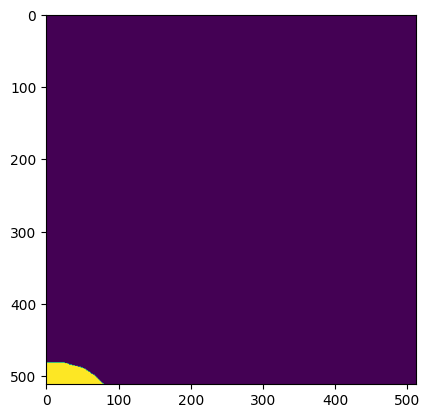

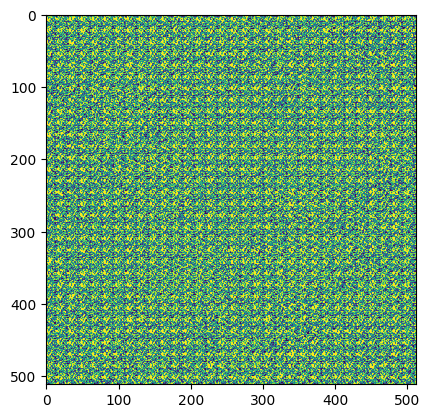

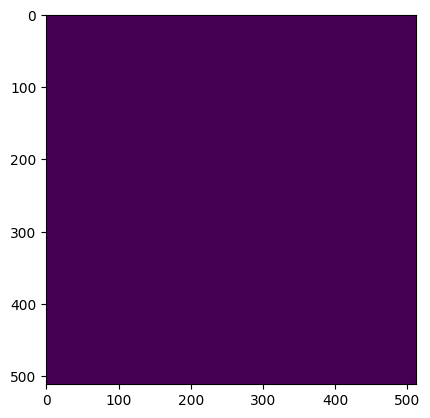

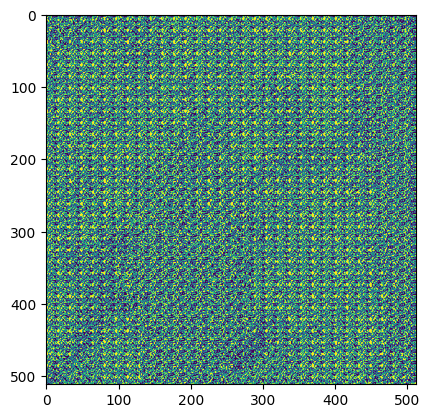

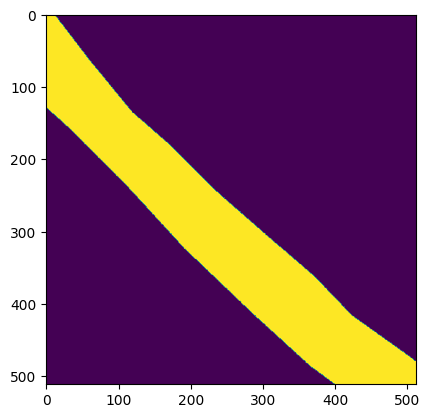

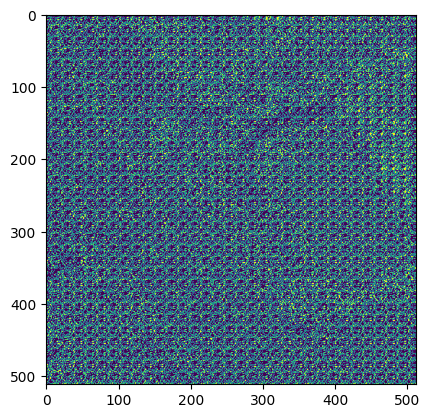

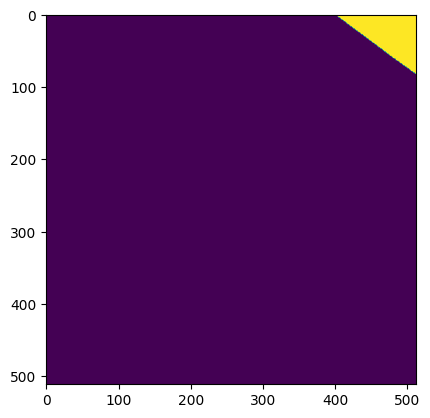

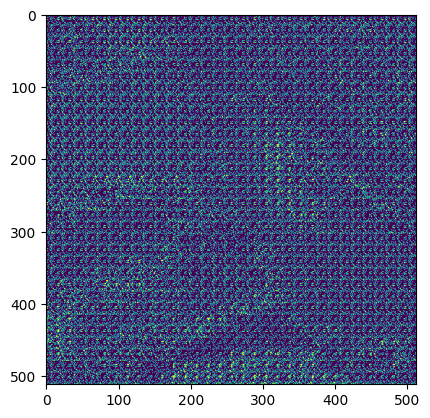

Epoch 1/1, Train Loss: 0.6983, Precision: 0.0578, Recall: 0.3879, F1: 0.1005, IoU: 0.0529
Epoch 1/1, Val Loss: 0.5169, Precision: 0.0346, Recall: 0.1890, F1: 0.0585, IoU: 0.0301


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# def hook_fn(module, input, output):
#     print(f"{module.__class__.__name__}: {output.shape}")

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_chans=5, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Attention Block
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        dp = (q @ k.transpose(-2, -1)) * self.scale
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).reshape(n_samples, n_tokens, dim)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim, p=p)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer for Segmentation
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=512,
        patch_size=16,
        in_chans=5,
        embed_dim=512, 
        depth=8, 
        n_heads=8, 
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.,
        attn_p=0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Segmentation head
        self.segmentation_head = nn.ConvTranspose2d(
            in_channels=embed_dim,
            out_channels=1,  # Binary segmentation
            kernel_size=patch_size,
            stride=patch_size,
        )
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Reshape to apply the segmentation head
        x = x.transpose(1, 2).view(n_samples, -1, int(self.patch_embed.n_patches**0.5), int(self.patch_embed.n_patches**0.5))
        x = self.segmentation_head(x)
        
        return torch.sigmoid(x)

# Dataset class for loading .tif images and masks using rasterio
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        return image, mask

# Initialize model
model = VisionTransformer(
    img_size=512,
    patch_size=16,
    in_chans=5,
    embed_dim=512,
    depth=8,
    n_heads=8,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.,
    attn_p=0.,
).to(device)


# # Register hooks on all layers
# for name, layer in model.named_modules():
#     layer.register_forward_hook(hook_fn)
    
# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 1

# Load data
train_dataset = SegmentationDataset('data/train/images', 'data/train/masks')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset('data/val/images', 'data/val/masks')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
#         print("training masks", np.count_nonzero(masks.cpu().detach().numpy() == 1))
        plt.imshow(np.transpose(masks[0].cpu().detach().numpy(),(1,2,0)))
        plt.show()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (outputs > 0.5).float()
#         print("training outputs",np.count_nonzero(preds.cpu().detach().numpy() == 1))
        plt.imshow(np.transpose(preds[0].cpu().detach().numpy(),(1,2,0)))
        plt.show()
        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(masks.detach().cpu().numpy())
    
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_precision = precision_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_recall = recall_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_f1 = f1_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    train_iou = jaccard_score(all_train_labels.flatten(), all_train_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
#             print("validation masks",np.count_nonzero(masks.cpu().detach().numpy() == 1))
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = (outputs > 0.5).float()
#             print("validation outputs",np.count_nonzero(preds.cpu().detach().numpy() == 1))
            all_val_preds.append(preds.detach().cpu().numpy())
            all_val_labels.append(masks.detach().cpu().numpy())
    
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_precision = precision_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_recall = recall_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_f1 = f1_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    val_iou = jaccard_score(all_val_labels.flatten(), all_val_preds.flatten(), zero_division=1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}")


In [49]:
z = torch.tensor([[1,2],[2,3]])

In [50]:
np.unique(z)

array([1, 2, 3], dtype=int64)

In [56]:
np.count_nonzero(z == 2)

2